# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from time import time
from timeit import default_timer as timer

from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from collections import Counter

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier


# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
%%time
# load in the data
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

<string>:2: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: user 6.41 s, sys: 912 ms, total: 7.32 s
Wall time: 14.6 s


In [12]:
%%time
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')

<string>:2: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: user 39.5 s, sys: 17.4 s, total: 56.9 s
Wall time: 11min 14s


In [3]:
azdias_sub = pd.read_csv("azdias_sub.csv", index_col=0)
customers_sub = pd.read_csv("customers_sub.csv", index_col=0)

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
attributes_values = pd.read_excel("DIAS Attributes - Values 2017.xlsx")
attributes_values.drop("Unnamed: 0", axis=1, inplace=True)
attributes_values["Attribute"] = attributes_values["Attribute"].ffill()
attributes_values["Description"] = attributes_values["Description"].ffill()

In [5]:
#azdias.head()
#azdias.describe()

In [98]:
#customers.head()
#customers.describe()

In [5]:
azdias_sub.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
726694,327141,1,1.0,10.0,NaN,NaN,NaN,NaN,10.0,11.0,...,1.0,5.0,4.0,2.0,6.0,9.0,3.0,3,2,4
773973,273987,2,1.0,18.0,NaN,NaN,NaN,NaN,11.0,1.0,...,4.0,3.0,3.0,2.0,2.0,9.0,7.0,1,1,3
144882,488417,-1,1.0,15.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,1.0,1.0,1.0,4.0,9.0,7.0,3,2,4
312137,330262,-1,9.0,0.0,NaN,NaN,NaN,NaN,NaN,5.0,...,3.0,7.0,10.0,8.0,6.0,5.0,7.0,3,2,3
794875,203814,-1,1.0,0.0,NaN,NaN,NaN,NaN,14.0,3.0,...,4.0,6.0,8.0,5.0,6.0,9.0,7.0,3,2,3


In [6]:
customers_sub.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
726694,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
773973,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
144882,15280.0,2.0,1.0,10.0,NaN,NaN,NaN,NaN,10.0,11.0,...,3.0,6.0,9.0,5.0,3.0,COSMETIC,SINGLE_BUYER,0.0,2.0,4.0
312137,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
794875,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
attributes_values.head(10)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,best-ager typology,0,no classification possible
2,AGER_TYP,best-ager typology,1,passive elderly
3,AGER_TYP,best-ager typology,2,cultural elderly
4,AGER_TYP,best-ager typology,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,ALTERSKATEGORIE_GROB,age classification through prename analysis,1,< 30 years
7,ALTERSKATEGORIE_GROB,age classification through prename analysis,2,30 - 45 years
8,ALTERSKATEGORIE_GROB,age classification through prename analysis,3,46 - 60 years
9,ALTERSKATEGORIE_GROB,age classification through prename analysis,4,> 60 years


### 0.1 Creating a subset
I want to create subsets of the files in order to have lower loading times while experimenting with the data.

In [94]:
azdias_sub = azdias.sample(frac=0.1, random_state=3, axis="index")
azdias_sub.to_csv("azdias_sub.csv")

In [41]:
sub_index_list = list(azdias_sub.index)

In [95]:
customers_sub = customers.loc[sub_index_list]
customers_sub.to_csv("customers_sub.csv")

### 0.2 Warning while loading
When loading the data I get the following warning: "DtypeWarning: Columns (18,19) have mixed types."
I will check these columns.

In [5]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [6]:
customers.iloc[:, 18:20].head()

,CAMEO_DEUG_2015,CAMEO_INTL_2015
0,1,13
1,NaN,NaN
2,5,34
3,4,24
4,7,41


In [7]:
customers.iloc[:, 18].unique()

array([1.0, nan, 5.0, 4.0, 7.0, 3.0, 9.0, 2.0, 6.0, 8.0, '6', '3', '8',
       '9', '2', '4', '1', '7', '5', 'X'], dtype=object)

In [8]:
customers.iloc[:, 19].unique()

array([13.0, nan, 34.0, 24.0, 41.0, 23.0, 15.0, 55.0, 14.0, 22.0, 43.0,
       51.0, 33.0, 25.0, 44.0, 54.0, 32.0, 12.0, 35.0, 31.0, 45.0, 52.0,
       '45', '25', '55', '51', '14', '54', '43', '22', '15', '24', '35',
       '23', '12', '44', '41', '52', '31', '13', '34', '32', '33', 'XX'], dtype=object)

The problem of mixed types in columns 18 and 19 is that there are numbers in float format and numbers in string format. Missing values are marked with "X" or "XX" in string format. All numbers should be in float format and unknown values should be represented as "NaN".

In [9]:
customers.iloc[:, 18:20] = customers.iloc[:, 18:20].replace(['X','XX'], np.nan)

In [10]:
customers.iloc[:, 18:20] = customers.iloc[:, 18:20].astype(float)

In [11]:
print(customers.iloc[:, 18].unique())
print(customers.iloc[:, 19].unique())

[  1.  nan   5.   4.   7.   3.   9.   2.   6.   8.]
[ 13.  nan  34.  24.  41.  23.  15.  55.  14.  22.  43.  51.  33.  25.  44.
  54.  32.  12.  35.  31.  45.  52.]


### 0.3 Load the Excel file with information about the values of the attributes
I want to check the information in the excel file. There are different values with the meaning "unknown". I will convert all values with meaning "unknown" to NaN.

In [3]:
attributes_values = pd.read_excel("DIAS Attributes - Values 2017.xlsx")
attributes_values.drop("Unnamed: 0", axis=1, inplace=True)
attributes_values.head(10)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,0,no classification possible
2,NaN,NaN,1,passive elderly
3,NaN,NaN,2,cultural elderly
4,NaN,NaN,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,NaN,NaN,1,< 30 years
7,NaN,NaN,2,30 - 45 years
8,NaN,NaN,3,46 - 60 years
9,NaN,NaN,4,> 60 years


In [6]:
attributes_values["Attribute"] = attributes_values["Attribute"].ffill()
attributes_values["Description"] = attributes_values["Description"].ffill()
attributes_values.head(10)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,best-ager typology,0,no classification possible
2,AGER_TYP,best-ager typology,1,passive elderly
3,AGER_TYP,best-ager typology,2,cultural elderly
4,AGER_TYP,best-ager typology,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,ALTERSKATEGORIE_GROB,age classification through prename analysis,1,< 30 years
7,ALTERSKATEGORIE_GROB,age classification through prename analysis,2,30 - 45 years
8,ALTERSKATEGORIE_GROB,age classification through prename analysis,3,46 - 60 years
9,ALTERSKATEGORIE_GROB,age classification through prename analysis,4,> 60 years


In [7]:
attributes_values[attributes_values["Meaning"] == "unknown"].head()
# "unknown / no main age detectable"
# "no transaction known"
# "no transactions known"

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
33,ANREDE_KZ,gender,"-1, 0",unknown
40,BALLRAUM,distance to next urban centre,-1,unknown
48,BIP_FLAG,business-flag indicating companies in the buil...,-1,unknown


In [8]:
attributes_values[attributes_values["Meaning"] == "unknown"]["Value"].unique()

array([-1, '-1, 0', 0, '-1, 9', '-1'], dtype=object)

In [9]:
attributes_values[(attributes_values["Attribute"] == "AGER_TYP") & (attributes_values["Meaning"] == "unknown")]

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown


In [10]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [12]:
words_list = ["unknown", "unknown / no main age detectable", "no transaction known", "no transactions known"]

In [36]:
print("Before")
customers.isnull().sum().sum()

Before


13864522

In [42]:
for col in customers.columns:
    for word in words_list:
        x = attributes_values[(attributes_values["Attribute"] == col) & (attributes_values["Meaning"] == word)]
        if len(x) == 0:
            continue
        idx = x.index[0]
        val = x["Value"][idx]
        if type(val) == int:
            customers[col] = customers[col].replace(int(val), np.nan)
        if type(val) == str:
            customers[col] = customers[col].replace(str(val), np.nan)

In [39]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2.0,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,NaN,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,NaN,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1.0,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,NaN,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [43]:
print("After")
customers.isnull().sum().sum()

After


17146195

### 0.4 Drop columns with many missing values

In [44]:
# Are there columns that have a high amount of missing values?
customers_missing = customers.isnull().sum()
customers_missing_percent = (customers_missing / len(customers)) * 100

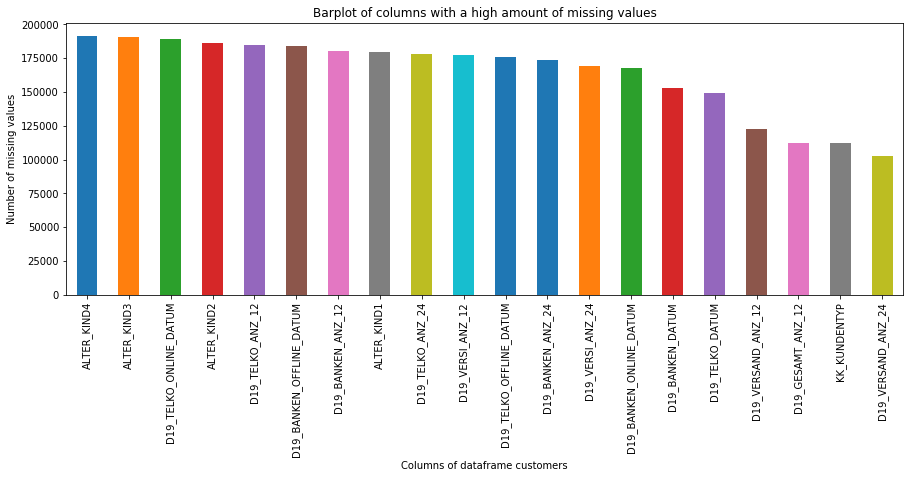

In [87]:
# Create a plot for better visualization
customers_missing.sort_values(ascending=False)[:20].plot(kind="bar", figsize=(15,5))
plt.xlabel("Columns of dataframe customers")
plt.ylabel("Number of missing values")
plt.title("Barplot of columns with a high amount of missing values");

In [59]:
# Show percentages
customers_missing_percent.sort_values(ascending=False).head(35)

ALTER_KIND4                  99.876860
ALTER_KIND3                  99.334732
D19_TELKO_ONLINE_DATUM       98.885480
ALTER_KIND2                  97.338927
D19_TELKO_ANZ_12             96.251017
D19_BANKEN_OFFLINE_DATUM     96.112746
D19_BANKEN_ANZ_12            93.998497
ALTER_KIND1                  93.860748
D19_TELKO_ANZ_24             93.091123
D19_VERSI_ANZ_12             92.478033
D19_TELKO_OFFLINE_DATUM      91.663536
D19_BANKEN_ANZ_24            90.633544
D19_VERSI_ANZ_24             88.093002
D19_BANKEN_ONLINE_DATUM      87.442343
D19_BANKEN_DATUM             79.708012
D19_TELKO_DATUM              77.700728
D19_VERSAND_ANZ_12           63.816709
D19_GESAMT_ANZ_12            58.438733
KK_KUNDENTYP                 58.406382
D19_VERSAND_ANZ_24           53.474005
D19_VERSAND_OFFLINE_DATUM    52.209734
D19_VERSAND_ONLINE_DATUM     50.929289
AGER_TYP                     48.059504
D19_GESAMT_ANZ_24            47.858619
D19_GESAMT_ONLINE_DATUM      46.876631
D19_GESAMT_OFFLINE_DATUM 

In [50]:
# These columns can be dropped because there is a high amount of missing values.
col_to_drop = customers_missing_percent.sort_values(ascending=False)[customers_missing_percent > 30].index
col_to_drop

Index(['ALTER_KIND4', 'ALTER_KIND3', 'D19_TELKO_ONLINE_DATUM', 'ALTER_KIND2',
       'D19_TELKO_ANZ_12', 'D19_BANKEN_OFFLINE_DATUM', 'D19_BANKEN_ANZ_12',
       'ALTER_KIND1', 'D19_TELKO_ANZ_24', 'D19_VERSI_ANZ_12',
       'D19_TELKO_OFFLINE_DATUM', 'D19_BANKEN_ANZ_24', 'D19_VERSI_ANZ_24',
       'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_DATUM', 'D19_TELKO_DATUM',
       'D19_VERSAND_ANZ_12', 'D19_GESAMT_ANZ_12', 'KK_KUNDENTYP',
       'D19_VERSAND_ANZ_24', 'D19_VERSAND_OFFLINE_DATUM',
       'D19_VERSAND_ONLINE_DATUM', 'AGER_TYP', 'D19_GESAMT_ANZ_24',
       'D19_GESAMT_ONLINE_DATUM', 'D19_GESAMT_OFFLINE_DATUM', 'EXTSEL992',
       'D19_VERSAND_DATUM', 'ALTER_HH', 'D19_GESAMT_DATUM'],
      dtype='object')

In [51]:
print("Before")
customers.shape

Before


(191652, 369)

In [52]:
customers.drop(columns=col_to_drop, inplace=True)

In [53]:
print("After")
customers.shape

After


(191652, 339)

### 0.5 Drop rows with many missing values

In [80]:
# Find the percentage of missing values NaN in each row of customers
customers_missing_row_percent = customers.isnull().mean(axis=1)

In [84]:
customers_missing_row_percent.head(20)

0     0.000000
1     0.710914
2     0.000000
3     0.008850
4     0.000000
5     0.000000
6     0.000000
7     0.000000
8     0.008850
9     0.000000
10    0.648968
11    0.000000
12    0.000000
13    0.188791
14    0.000000
15    0.000000
16    0.000000
17    0.000000
18    0.000000
19    0.000000
dtype: float64

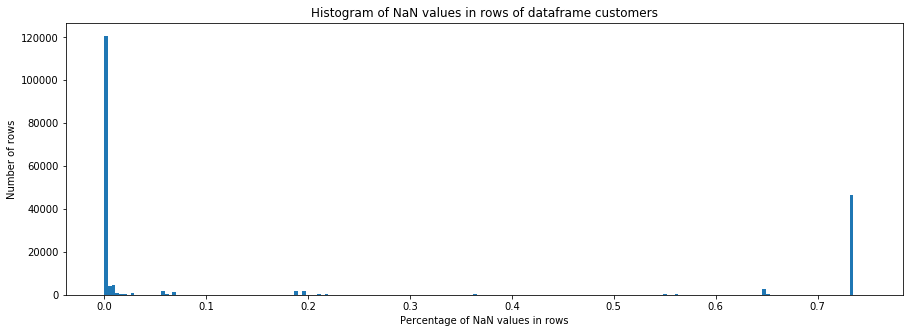

In [88]:
# Create a plot for better visualization
customers_missing_row_percent.plot(kind="hist", bins=200, figsize=(15,5))
plt.xlabel("Percentage of NaN values in rows")
plt.ylabel("Number of rows")
plt.title("Histogram of NaN values in rows of dataframe customers");

In [89]:
# These rows can be dropped because there is a high amount of missing values.
rows_to_drop = customers_missing_row_percent.sort_values(ascending=False)[customers_missing_row_percent > 0.2].index
rows_to_drop

Int64Index([ 74012,  84107,  89983,  95825, 132498, 132511, 132510, 132509,
             35683, 132506,
            ...
             54723,  46922,  48482, 182418,  45964,  78629, 100235, 169383,
             97176, 135872],
           dtype='int64', length=52690)

In [91]:
print("Before")
customers.shape

Before


(191652, 339)

In [92]:
customers.drop(index=rows_to_drop, inplace=True)

In [93]:
print("After")
customers.shape

After


(138962, 339)

### 0.6 Creating a function for cleaning the dataframes
This function will perform all steps from the cells before.

In [4]:
def cleaning_function(df, attributes_values):
    # Repairing the warning of mixed types in two columns
    print("Step 1: Repairing the warning of mixed types in two columns")
    df.iloc[:, 18:20] = df.iloc[:, 18:20].replace(['X','XX'], np.nan)
    df.iloc[:, 18:20] = df.iloc[:, 18:20].astype(float)
    
    # Converting all values with meaning "unknown" to NaN
    print("Step 2: Converting all values with meaning 'unknown' to NaN")
    words_list = ["unknown", "unknown / no main age detectable", "no transaction known", "no transactions known"]
    print("Sum NaN values before:", df.isnull().sum().sum())
    for col in df.columns:
        for word in words_list:
            x = attributes_values[(attributes_values["Attribute"] == col) & (attributes_values["Meaning"] == word)]
            if len(x) == 0:
                continue
            idx = x.index[0]
            val = x["Value"][idx]
            if type(val) == int:
                df[col] = df[col].replace(int(val), np.nan)
            if type(val) == str:
                df[col] = df[col].replace(str(val), np.nan)
    print("Sum NaN values after: ", df.isnull().sum().sum())
    
    # Determine columns with many missing values
    print ("Step 3: Determining columns with many missing values")
    df_missing = df.isnull().sum()
    df_missing_percent = (df_missing / len(df)) * 100
    col_to_drop = df_missing_percent.sort_values(ascending=False)[df_missing_percent > 30].index

    # Dropping rows with many missing values
    print ("Step 4: Dropping rows with many missing values")
    df_missing_row_percent = df.isnull().mean(axis=1)
    rows_to_drop = df_missing_row_percent.sort_values(ascending=False)[df_missing_row_percent > 0.2].index
    print("Shape before:", df.shape)
    df.drop(index=rows_to_drop, inplace=True)
    print("Shape after: ", df.shape)
    print("Finished")
    
    return df, col_to_drop


def dropping_function(df, col_to_drop):
    # Dropping columns with many missing values
    print("Dropping columns with many missing values")
    print("Shape before:", df.shape)
    df.drop(columns=col_to_drop, inplace=True)
    print("Shape after: ", df.shape)
    print("Finished")
    
    return df

In [8]:
# CUSTOMERS
df_customers, col_to_drop_customers = cleaning_function(customers, attributes_values)

Step 1: Repairing the warning of mixed types in two columns
Step 2: Converting all values with meaning 'unknown' to NaN
Sum NaN values before 13864774
Sum NaN values after  17146447
Step 3: Determining rows with many missing values
Step 4: Dropping rows with many missing values
Shape before (191652, 369)
Shape after  (135201, 369)
Finished


In [9]:
# CUSTOMERS
df_customers = dropping_function(df_customers, col_to_drop_customers)

Dropping columns with many missing values
Shape before (135201, 369)
Shape after  (135201, 339)
Finished


In [14]:
# AZIDAS
df_azdias, col_to_drop_azdias = cleaning_function(azdias, attributes_values)

Step 1: Repairing the warning of mixed types in two columns
Step 2: Converting all values with meaning 'unknown' to NaN
Sum NaN values before 33493669
Sum NaN values after  49516860
Step 3: Determining rows with many missing values
Step 4: Dropping rows with many missing values
Shape before (891221, 366)
Shape after  (751678, 366)
Finished


In [15]:
# AZDIAS
df_azdias = dropping_function(df_azdias, col_to_drop_azdias)

Dropping columns with many missing values
Shape before (751678, 366)
Shape after  (751678, 336)
Finished


In [10]:
df_customers.head()

,LNR,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,1.0,10.0,1.0,0.0,0.0,2.0,1.0,0.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
2,143872,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,3.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1.0,8.0,0.0,NaN,0.0,0.0,1.0,0.0,1.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,1.0,14.0,7.0,0.0,0.0,4.0,7.0,0.0,3.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3
5,143888,1.0,10.0,1.0,0.0,0.0,2.0,1.0,0.0,3.0,...,1.0,6.0,9.0,1.0,2,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,3


In [16]:
df_azdias.head()

,LNR,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
1,910220,9.0,21.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,9.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,1.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,1.0,14.0,3.0,0.0,0.0,4.0,3.0,0.0,4.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3
5,910244,1.0,10.0,5.0,0.0,0.0,1.0,2.0,0.0,2.0,...,2.0,10.0,7.0,4.0,6.0,9.0,7.0,4,2,1


In [11]:
col_to_drop_customers

Index(['ALTER_KIND4', 'ALTER_KIND3', 'D19_TELKO_ONLINE_DATUM', 'ALTER_KIND2',
       'D19_TELKO_ANZ_12', 'D19_BANKEN_OFFLINE_DATUM', 'D19_BANKEN_ANZ_12',
       'ALTER_KIND1', 'D19_TELKO_ANZ_24', 'D19_VERSI_ANZ_12',
       'D19_TELKO_OFFLINE_DATUM', 'D19_BANKEN_ANZ_24', 'D19_VERSI_ANZ_24',
       'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_DATUM', 'D19_TELKO_DATUM',
       'D19_VERSAND_ANZ_12', 'D19_GESAMT_ANZ_12', 'KK_KUNDENTYP',
       'D19_VERSAND_ANZ_24', 'D19_VERSAND_OFFLINE_DATUM',
       'D19_VERSAND_ONLINE_DATUM', 'AGER_TYP', 'D19_GESAMT_ANZ_24',
       'D19_GESAMT_ONLINE_DATUM', 'D19_GESAMT_OFFLINE_DATUM', 'EXTSEL992',
       'D19_VERSAND_DATUM', 'ALTER_HH', 'D19_GESAMT_DATUM'],
      dtype='object')

In [17]:
col_to_drop_azdias

Index(['ALTER_KIND4', 'ALTER_KIND3', 'D19_TELKO_ONLINE_DATUM',
       'D19_BANKEN_OFFLINE_DATUM', 'ALTER_KIND2', 'D19_TELKO_ANZ_12',
       'D19_BANKEN_ANZ_12', 'D19_TELKO_ANZ_24', 'D19_VERSI_ANZ_12',
       'D19_TELKO_OFFLINE_DATUM', 'ALTER_KIND1', 'D19_BANKEN_ANZ_24',
       'D19_VERSI_ANZ_24', 'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_DATUM',
       'AGER_TYP', 'D19_TELKO_DATUM', 'EXTSEL992', 'D19_VERSAND_ANZ_12',
       'D19_VERSAND_OFFLINE_DATUM', 'D19_GESAMT_ANZ_12', 'KK_KUNDENTYP',
       'D19_VERSAND_ANZ_24', 'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ANZ_24',
       'D19_VERSAND_ONLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM',
       'D19_VERSAND_DATUM', 'D19_GESAMT_DATUM', 'ALTER_HH'],
      dtype='object')

### 0.7 Saving data for the next part

In [18]:
df_customers.to_pickle("df_customers.pkl")

In [19]:
df_azdias.to_pickle("df_azdias.pkl")

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [63]:
%%time
# Load data
df_customers = pd.read_pickle("df_customers.pkl")
#df_azdias = pd.read_pickle("df_azdias.pkl")

CPU times: user 85.6 ms, sys: 476 ms, total: 561 ms
Wall time: 2.66 s


In [3]:
df_customers.head()

,LNR,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,1.0,10.0,1.0,0.0,0.0,2.0,1.0,0.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
2,143872,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,3.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1.0,8.0,0.0,NaN,0.0,0.0,1.0,0.0,1.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,1.0,14.0,7.0,0.0,0.0,4.0,7.0,0.0,3.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3
5,143888,1.0,10.0,1.0,0.0,0.0,2.0,1.0,0.0,3.0,...,1.0,6.0,9.0,1.0,2,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,3


In [6]:
df_azdias.head()

,LNR,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
1,910220,9.0,21.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,9.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,1.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,1.0,14.0,3.0,0.0,0.0,4.0,3.0,0.0,4.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3
5,910244,1.0,10.0,5.0,0.0,0.0,1.0,2.0,0.0,2.0,...,2.0,10.0,7.0,4.0,6.0,9.0,7.0,4,2,1


In [3]:
# Dropping columns with non-float values
col_to_drop_customers = ["CUSTOMER_GROUP", "PRODUCT_GROUP", "OST_WEST_KZ", "EINGEFUEGT_AM",
                        "D19_LETZTER_KAUF_BRANCHE", "CAMEO_DEU_2015"]
col_to_drop_azdias = ["OST_WEST_KZ", "EINGEFUEGT_AM", "D19_LETZTER_KAUF_BRANCHE", "CAMEO_DEU_2015"]

In [4]:
# CUSTOMERS
print("Shape CUSTOMERS before:", df_customers.shape)
df_customers.drop(columns=col_to_drop_customers, inplace=True)
print("Shape CUSTOMERS after: ", df_customers.shape)

Shape CUSTOMERS before: (135201, 339)
Shape CUSTOMERS after:  (135201, 333)


In [47]:
# AZDIAS
print("Shape AZDIAS before:", df_azdias.shape)
df_azdias.drop(columns=col_to_drop_azdias, inplace=True)
print("Shape AZDIAS after: ", df_azdias.shape)

Shape AZDIAS before: (751678, 336)
Shape AZDIAS after:  (751678, 332)


### 1.1 Imputing NaN Values
I will impute the NaN Values with the median method.

In [6]:
imputer = Imputer(missing_values=np.nan, strategy="median")

In [5]:
df_customers.columns[df_customers.isnull().sum() > 0]

Index(['ALTERSKATEGORIE_FEIN', 'ANZ_HH_TITEL', 'ARBEIT', 'BALLRAUM',
       'CAMEO_DEUG_2015', 'CAMEO_INTL_2015', 'CJT_GESAMTTYP',
       'CJT_KATALOGNUTZER', 'CJT_TYP_1', 'CJT_TYP_2',
       ...
       'STRUKTURTYP', 'UMFELD_ALT', 'UMFELD_JUNG', 'VERDICHTUNGSRAUM',
       'VERS_TYP', 'VHN', 'VK_DHT4A', 'VK_DISTANZ', 'VK_ZG11',
       'W_KEIT_KIND_HH'],
      dtype='object', length=126)

In [7]:
# CUSTOMERS
customers_imputed = pd.DataFrame(imputer.fit_transform(df_customers))

In [8]:
customers_imputed.isnull().sum().sum()

0

In [48]:
df_azdias.columns[df_azdias.isnull().sum() > 0]

Index(['ALTERSKATEGORIE_FEIN', 'ANZ_HH_TITEL', 'ARBEIT', 'BALLRAUM',
       'CAMEO_DEUG_2015', 'CAMEO_INTL_2015', 'CJT_GESAMTTYP',
       'CJT_KATALOGNUTZER', 'CJT_TYP_1', 'CJT_TYP_2',
       ...
       'STRUKTURTYP', 'UMFELD_ALT', 'UMFELD_JUNG', 'VERDICHTUNGSRAUM',
       'VERS_TYP', 'VHN', 'VK_DHT4A', 'VK_DISTANZ', 'VK_ZG11',
       'W_KEIT_KIND_HH'],
      dtype='object', length=129)

In [49]:
# AZIDAS
azdias_imputed = pd.DataFrame(imputer.fit_transform(df_azdias))

In [50]:
azdias_imputed.isnull().sum().sum()

0

### 1.2 Feature Scaling
In order to prevent the principal component vectors to be influenced by the natural differences in scale of the features, I will now scale the features.

In [9]:
scaler = StandardScaler()

In [10]:
# CUSTOMERS
customers_scaled = pd.DataFrame(scaler.fit_transform(customers_imputed))

In [51]:
# AZDIAS
azdias_scaled = pd.DataFrame(scaler.fit_transform(azdias_imputed))

### 1.3 Dimensionality Reduction - PCA - Principal Component Analysis
I will know perform Principal Component Analysis, because although I dropped some columns the data is still high dimensional. With PCA I will reduce the number of features within the datasets.

In [11]:
pca = PCA()

In [12]:
customers_pca = pd.DataFrame(pca.fit_transform(customers_scaled))

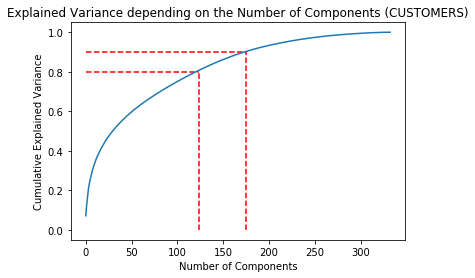

In [13]:
# CUSTOMERS
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title("Explained Variance depending on the Number of Components (CUSTOMERS)")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.hlines(y=0.8, xmin=0, xmax=123, color="red", linestyles="--")
plt.vlines(x=123, ymin=0, ymax=0.8, color="red", linestyles="--")
plt.hlines(y=0.9, xmin=0, xmax=175, color="red", linestyles="--")
plt.vlines(x=175, ymin=0, ymax=0.9, color="red", linestyles="--")
plt.show()

With the help of this plot I will choose the number of features/components that I want to keep after PCA. It seems that n = 175 is a reasonable number to choose.

In [14]:
def reduce_dimension(df, n):
    pca2 = PCA(n_components=n)
    reduced_df = pd.DataFrame(pca2.fit_transform(df))
    print("After reducing the number of components to " + str(n) + 
          " the cumulative explained variance is equal to " + str(pca2.explained_variance_ratio_.sum()))
    
    return reduced_df

In [15]:
# CUSTOMERS
reduced_customers_123 = reduce_dimension(customers_scaled, n=123)
reduced_customers_123.shape

After reducing the number of components to 123 the cumulative explained variance is equal to 0.800780122161


(135201, 123)

In [16]:
# CUSTOMERS
reduced_customers_175 = reduce_dimension(customers_scaled, n=175)
reduced_customers_175.shape

After reducing the number of components to 175 the cumulative explained variance is equal to 0.900156109202


(135201, 175)

In [55]:
# AZDIAS
reduced_azdias_175 = reduce_dimension(azdias_scaled, n=175)
reduced_azdias_175.shape

After reducing the number of components to 175 the cumulative explained variance is equal to 0.914301825079


(751678, 175)

### 1.4 k-Means Clustering

In [17]:
def apply_kmeans(data, k):
    kmeans = KMeans(n_clusters=k)
    model = kmeans.fit(data)
    
    return abs(model.score(data))

Current number of clusters:  1
Current number of clusters:  2
Current number of clusters:  3
Current number of clusters:  4
Current number of clusters:  5
Current number of clusters:  6
Current number of clusters:  7
Current number of clusters:  8
Current number of clusters:  9
Current number of clusters:  10
Current number of clusters:  11
Current number of clusters:  12
Current number of clusters:  13
Current number of clusters:  14
Current number of clusters:  15
Current number of clusters:  16
Current number of clusters:  17
Current number of clusters:  18
Current number of clusters:  19
Current number of clusters:  20
CPU times: user 3min 40s, sys: 5.6 s, total: 3min 46s
Wall time: 3min 48s


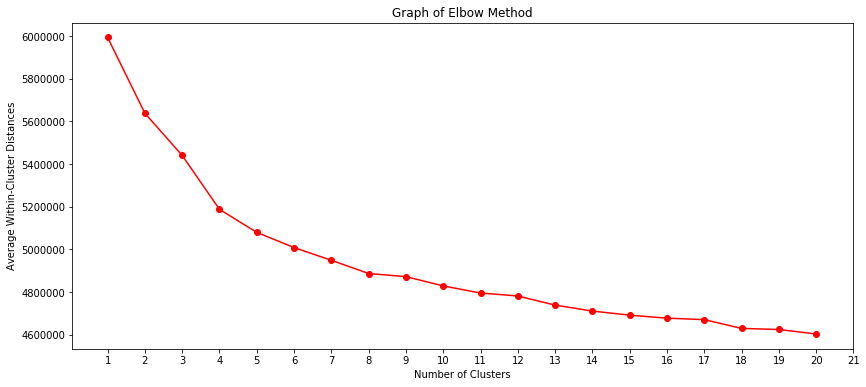

In [18]:
%%time
distances = []
for cluster in range(1, 21):
    print("Current number of clusters: ", cluster)
    distances.append(apply_kmeans(reduced_customers_175.sample(20000), cluster))
cluster_amt = np.linspace(1,20,20)
plt.figure(figsize=(14,6))
plt.plot(cluster_amt, distances, linestyle="-", marker="o", color="red")
plt.xticks(list(range(1,22,1)))
plt.xlabel("Number of Clusters")
plt.ylabel("Average Within-Cluster Distances")
plt.title("Graph of Elbow Method");

In the above plot I can see that the average within-cluster distance flattens at 9 and at 12 clusters. 9 seems to be a bit low therefore I will use 12 as the number of clusters.

In [66]:
%%time
# k-means with 12 clusters
kmeans = KMeans(n_clusters=12, random_state=3)

# predictions
customers_predictions = kmeans.fit_predict(reduced_customers_175)
azdias_predictions = kmeans.fit_predict(reduced_azdias_175)

CPU times: user 12min 25s, sys: 2min 8s, total: 14min 34s
Wall time: 16min 34s


In [75]:
# CUSTOMERS
customers_proportions = Counter()
for item in customers_predictions:
    customers_proportions[item] += 1
customers_proportions

Counter({3: 17729,
         10: 12020,
         1: 17497,
         6: 5265,
         2: 10694,
         4: 7085,
         7: 16729,
         0: 12474,
         8: 11236,
         5: 8385,
         11: 15189,
         9: 898})

In [76]:
# AZDIAS
azdias_proportions = Counter()
for item in azdias_predictions:
    azdias_proportions[item] += 1
azdias_proportions

Counter({8: 94425,
         5: 88646,
         10: 81103,
         2: 55885,
         3: 98670,
         1: 74263,
         6: 68330,
         0: 74594,
         4: 14043,
         7: 47591,
         11: 52616,
         9: 1512})

In [77]:
for k, v in customers_proportions.items():
    customers_proportions[k] = v / len(reduced_customers_175)

for k, v in azdias_proportions.items():
    azdias_proportions[k] = v / len(reduced_azdias_175)

In [81]:
df_props = pd.DataFrame(columns=["Dataset", "Cluster", "Proportions", 'Difference'])
for k, v in customers_proportions.items():
    df_props = df_props.append({"Dataset" : "customers", "Cluster": k, "Proportions": v}, ignore_index=True)

for k, v in azdias_proportions.items():
    df_props = df_props.append({"Dataset" : "azdias", "Cluster": k, "Proportions": v}, ignore_index=True)

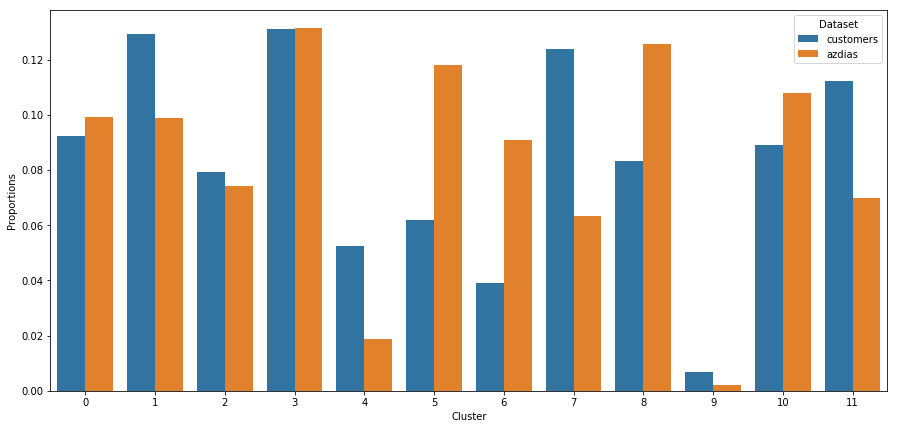

In [82]:
fig = plt.figure(figsize=(15,7))
sns.barplot(x="Cluster", y="Proportions", hue="Dataset", data=df_props);

When comparing the general and customer populations I can see that there are clusters that are overrepresented as well as underrepresented by the customer population.

The clusters with the highest amount of overrepresentation (customers) are: cluster 1, cluster 4, cluster 7 and cluster 11. This suggest that people in these clusters are more likely to be the target audience for the company.

The clusters that are most underrepresentated are cluster 5, cluster 6, cluster 8 and cluster 10.

### 1.5 Creating a function for preparing the dataframes

In [11]:
def preparing_function(df, sign):
    # Dropping columns with non-float values
    print("Step 1: Dropping columns with non-float values")
    if sign == "CUSTOMERS":
        col_to_drop = ["CUSTOMER_GROUP", "PRODUCT_GROUP", "OST_WEST_KZ", "EINGEFUEGT_AM", 
                       "D19_LETZTER_KAUF_BRANCHE", "CAMEO_DEU_2015"]
    if sign == "AZDIAS" or "MAILOUT_TRAIN" or "MAILOUT_TEST":
        col_to_drop = ["OST_WEST_KZ", "EINGEFUEGT_AM", "D19_LETZTER_KAUF_BRANCHE", "CAMEO_DEU_2015"]
    print("Shape " + sign + " before:", df.shape)
    df.drop(columns=col_to_drop, inplace=True)
    print("Shape " + sign + " after: ", df.shape)
    
    # Imputing NaN Values
    print("Step 2: Imputing NaN Values")
    imputer = Imputer(missing_values=np.nan, strategy='median')
    df_imputed = pd.DataFrame(imputer.fit_transform(df))
    
    # Feature Scaling
    print("Step 3: Feature Scaling")
    scaler = StandardScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df_imputed))
    
    # Dimensionality Reduction - PCA - Principal Component Analysis
    print("Step 4: Dimensionality Reduction - PCA - Principal Component Analysis")
    pca = PCA(n_components=175)
    reduced_df_175 = pd.DataFrame(pca.fit_transform(df_scaled))
    print("After reducing the number of components to 175 the cumulative explained variance is equal to " + 
          str(pca.explained_variance_ratio_.sum()))

    return reduced_df_175

In [64]:
# CUSTOMERS
reduced_customers_175 = preparing_function(df_customers, "CUSTOMERS")

Step 1: Dropping columns with non-float values
Shape CUSTOMERS before: (135201, 339)
Shape CUSTOMERS after:  (135201, 333)
Step 2: Imputing NaN Values
Step 3: Feature Scaling
Step 4: Dimensionality Reduction - PCA - Principal Component Analysis
After reducing the number of components to 175 the cumulative explained variance is equal to 0.900419361939


### 1.6 Saving data for the next part

In [65]:
reduced_customers_175.to_pickle("reduced_customers_175.pkl")

In [57]:
reduced_azdias_175.to_pickle("reduced_azdias_175.pkl")

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [21]:
%%time
# Load data
reduced_customers_175 = pd.read_pickle("reduced_customers_175.pkl")
reduced_azdias_175 = pd.read_pickle("reduced_azdias_175.pkl")
reduced_mailout_train_175 = pd.read_pickle("reduced_mailout_train_175.pkl")
y = pd.read_pickle("y.pkl")

CPU times: user 347 ms, sys: 2.15 s, total: 2.5 s
Wall time: 13.5 s


In [22]:
# Remember: y = df_mailout_train["RESPONSE"]
X = reduced_mailout_train_175

In [4]:
print(X.shape, y.shape)

(34225, 175) (34225,)


In [5]:
# Logistic Regression
lr = LogisticRegression(random_state=3)
lr.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=3, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [6]:
y_pred = lr.predict_proba(X)[:,1]
print('Accuracy of logistic regression classifier: {:.2f}'.format(lr.score(X, y)))
print('Logistic regression ROC-AUC: {:.2f}'.format(roc_auc_score(y, y_pred)))

Accuracy of logistic regression classifier: 0.99
Logistic regression ROC-AUC: 0.79


In [23]:
def classifier_fitting(classifier, parameters={}, X=X, y=y):
    start = timer()
    model = GridSearchCV(estimator=classifier, param_grid=parameters, scoring="roc_auc", verbose=3)
    model.fit(X, y)
    end = timer()
    print("Duration:", end - start, "seconds")
    print("Best Score:", model.best_score_)
    
    return model.best_estimator_, model.best_params_

### 2.1 Editing the new datasets

In [6]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
print(mailout_train.shape)
mailout_train.head()

(42962, 367)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [9]:
df_mailout_train, col_to_drop_mailout_train = cleaning_function(mailout_train, attributes_values)

Step 1: Repairing the warning of mixed types in two columns
Step 2: Converting all values with meaning 'unknown' to NaN
Sum NaN values before: 2217201
Sum NaN values after:  2931424
Step 3: Determining rows with many missing values
Step 4: Dropping rows with many missing values
Shape before: (42962, 367)
Shape after:  (34225, 367)
Finished


In [10]:
col_to_drop_mailout_train

Index(['ALTER_KIND4', 'ALTER_KIND3', 'D19_TELKO_ONLINE_DATUM', 'ALTER_KIND2',
       'D19_BANKEN_OFFLINE_DATUM', 'D19_TELKO_ANZ_12', 'ALTER_KIND1',
       'D19_BANKEN_ANZ_12', 'D19_TELKO_ANZ_24', 'D19_VERSI_ANZ_12',
       'D19_TELKO_OFFLINE_DATUM', 'D19_BANKEN_ANZ_24', 'D19_VERSI_ANZ_24',
       'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_DATUM', 'D19_TELKO_DATUM',
       'D19_VERSAND_ANZ_12', 'D19_GESAMT_ANZ_12', 'KK_KUNDENTYP',
       'D19_VERSAND_ANZ_24', 'D19_VERSAND_ONLINE_DATUM', 'D19_GESAMT_ANZ_24',
       'D19_VERSAND_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM',
       'D19_GESAMT_OFFLINE_DATUM', 'AGER_TYP', 'EXTSEL992',
       'D19_VERSAND_DATUM', 'ALTER_HH'],
      dtype='object')

In [11]:
df_mailout_train = dropping_function(df_mailout_train, col_to_drop_mailout_train)

Dropping columns with many missing values
Shape before: (34225, 367)
Shape after:  (34225, 338)
Finished


In [12]:
y = df_mailout_train["RESPONSE"]
print("Shape before:", df_mailout_train.shape)
df_mailout_train.drop(columns=["RESPONSE"], inplace=True)
print("Shape after: ", df_mailout_train.shape)

Shape before: (34225, 338)
Shape after:  (34225, 337)


In [13]:
reduced_mailout_train_175 = preparing_function(df_mailout_train, "MAILOUT_TRAIN")

Step 1: Dropping columns with non-float values
Shape MAILOUT_TRAIN before: (34225, 337)
Shape MAILOUT_TRAIN after:  (34225, 333)
Step 2: Imputing NaN Values
Step 3: Feature Scaling
Step 4: Dimensionality Reduction - PCA - Principal Component Analysis
After reducing the number of components to 175 the cumulative explained variance is equal to 0.907786221433


In [19]:
y.to_pickle("y.pkl")
reduced_mailout_train_175.to_pickle("reduced_mailout_train_175.pkl")

### 2.2 Random Forest Classifier

In [20]:
random_forest_clf = RandomForestClassifier(random_state=3)

In [21]:
classifier_fitting(random_forest_clf)

Duration: 31.686005069999965 seconds
Best Score: 0.503165698846


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=3, verbose=0, warm_start=False)

### 2.3 Gradient Boosting Classifier

In [22]:
gradient_boosting_clf = GradientBoostingClassifier(random_state=3)

In [23]:
classifier_fitting(gradient_boosting_clf)

Duration: 223.298238073 seconds
Best Score: 0.591128611076


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=3, subsample=1.0, verbose=0,
              warm_start=False)

### 2.4 AdaBoost Classifier

In [24]:
adaboost_clf = AdaBoostClassifier(random_state=3)

In [25]:
classifier_fitting(adaboost_clf)

Duration: 133.16247340400014 seconds
Best Score: 0.590701955046


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=3)

### 2.5 Decision Tree Classifier

In [26]:
decision_tree_clf = DecisionTreeClassifier(random_state=3)

In [27]:
classifier_fitting(decision_tree_clf)

Duration: 115.34899232600014 seconds
Best Score: 0.50622097477


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=3,
            splitter='best')

#### Overview
RandomForestClassifier:
- Duration: 30.205832796000323 seconds
- Best Score: 0.503275558282

GradientBoostingClassifier:
- Duration: 230.0230927099983 seconds
- Best Score: 0.604178063841

AdaBoostClassifier:
- Duration: 135.0154272050022 seconds
- Best Score: 0.577525793339

DecisionTreeClassifier:
- Duration: 107.53774769700249 seconds
- Best Score: 0.498791789686

### 2.6 Selecting the best Model and optimizing its parameters
After comparing the computed ROC-AUC-scores and the durations for each classifier, it seems that the Gradient Boosting Classifier is the best choice for further optimization.

In [60]:
gradient_boosting_clf = GradientBoostingClassifier(random_state=3)

parameters = {#"max_depth": [2, 3, 4] #5, 6, 7
              #"learning_rate": [0.15, 0.1, 0.05] #0.01, 0.005, 0.001
              #"n_estimators": [100, 250, 500, 750] #1000, 1250, 1500, 1750
              #"min_samples_split": [2, 4, 6, 8] #10, 20, 40, 60, 100
              #"min_samples_leaf": [1, 3, 5] #7, 9
              "max_features": [2, 3, 4, 5] #6, 7
             }
# max_depth: 2
# learning_rate: 0.15
# n_estimators: 750
# min_samples_split: 6
# min_samples_leaf: 3
# max_features: 4

In [61]:
%%time
gbc_best_estimator, gbc_best_params_= classifier_fitting(gradient_boosting_clf, parameters)
gbc_best_estimator

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] max_features=4 ..................................................
[CV] ......... max_features=4, score=0.5946444621398399, total=   2.0s
[CV] max_features=4 ..................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s


[CV] ......... max_features=4, score=0.6042267413717458, total=   2.0s
[CV] max_features=4 ..................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.2s remaining:    0.0s


[CV] ......... max_features=4, score=0.6540892973706557, total=   2.0s
[CV] max_features=5 ..................................................
[CV] ......... max_features=5, score=0.5933393919923196, total=   2.3s
[CV] max_features=5 ..................................................
[CV] ......... max_features=5, score=0.6137845600690399, total=   2.4s
[CV] max_features=5 ..................................................
[CV] ......... max_features=5, score=0.6112987970266522, total=   2.2s


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   13.5s finished


Duration: 17.007543396000983 seconds
Best Score: 0.617652828007
CPU times: user 16.5 s, sys: 228 ms, total: 16.7 s
Wall time: 17 s


In [62]:
gbc_best_params_

{'max_features': 4}

In [8]:
gradient_boosting_clf = GradientBoostingClassifier(random_state=3)

parameters = {"max_depth": [2],
              "learning_rate": [0.15],
              "n_estimators": [750],
              "min_samples_split": [6],
              "min_samples_leaf": [3],
              "max_features": [4]
             }

In [9]:
%%time
gbc_best_estimator, gbc_best_params_= classifier_fitting(gradient_boosting_clf, parameters)
gbc_best_estimator

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] learning_rate=0.15, max_depth=2, max_features=4, min_samples_leaf=3, min_samples_split=6, n_estimators=750 
[CV]  learning_rate=0.15, max_depth=2, max_features=4, min_samples_leaf=3, min_samples_split=6, n_estimators=750, score=0.6155830875909579, total=   8.7s
[CV] learning_rate=0.15, max_depth=2, max_features=4, min_samples_leaf=3, min_samples_split=6, n_estimators=750 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.3s remaining:    0.0s


[CV]  learning_rate=0.15, max_depth=2, max_features=4, min_samples_leaf=3, min_samples_split=6, n_estimators=750, score=0.6149673275435008, total=   8.5s
[CV] learning_rate=0.15, max_depth=2, max_features=4, min_samples_leaf=3, min_samples_split=6, n_estimators=750 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   18.3s remaining:    0.0s


[CV]  learning_rate=0.15, max_depth=2, max_features=4, min_samples_leaf=3, min_samples_split=6, n_estimators=750, score=0.6274301339441675, total=   8.7s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   27.5s finished


Duration: 40.102412749999985 seconds
Best Score: 0.619326740306
CPU times: user 39.3 s, sys: 249 ms, total: 39.5 s
Wall time: 40.1 s


Unfortunately, the score of the Gradient Boosting Classifier did not increase very much after optimizing the parameters. There is only a slight increase from 0.604 to 0.619

### 2.7 Predictions on the TEST dataset

In [6]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
print(mailout_test.shape)
mailout_test.head()

(42833, 366)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


In [8]:
df_mailout_test, col_to_drop_mailout_test = cleaning_function(mailout_test, attributes_values)

Step 1: Repairing the warning of mixed types in two columns
Step 2: Converting all values with meaning 'unknown' to NaN
Sum NaN values before: 2186771
Sum NaN values after:  2565511
Step 3: Determining columns with many missing values
Step 4: Dropping rows with many missing values
Shape before: (42833, 366)
Shape after:  (34259, 366)
Finished


In [9]:
col_to_drop_mailout_test

Index(['ALTER_KIND4', 'ALTER_KIND3', 'ALTER_KIND2', 'D19_TELKO_ANZ_12',
       'ALTER_KIND1', 'D19_BANKEN_ANZ_12', 'D19_TELKO_ANZ_24',
       'D19_VERSI_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_VERSI_ANZ_24',
       'D19_VERSAND_ANZ_12', 'D19_GESAMT_ANZ_12', 'KK_KUNDENTYP',
       'D19_VERSAND_ANZ_24', 'D19_GESAMT_ANZ_24', 'AGER_TYP', 'EXTSEL992',
       'ALTER_HH'],
      dtype='object')

In [10]:
df_mailout_test = dropping_function(df_mailout_test, col_to_drop_mailout_test)

Dropping columns with many missing values
Shape before: (34259, 366)
Shape after:  (34259, 348)
Finished


In [12]:
reduced_mailout_test_175 = preparing_function(df_mailout_test, "MAILOUT_TEST")

Step 1: Dropping columns with non-float values
Shape MAILOUT_TEST before: (34259, 348)
Shape MAILOUT_TEST after:  (34259, 344)
Step 2: Imputing NaN Values
Step 3: Feature Scaling
Step 4: Dimensionality Reduction - PCA - Principal Component Analysis
After reducing the number of components to 175 the cumulative explained variance is equal to 0.903480037504


In [14]:
df_mailout_test.head()

,LNR,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,1.0,6.0,2.0,0.0,0.0,2.0,2.0,0.0,3.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,1.0,0.0,20.0,0.0,0.0,1.0,21.0,0.0,4.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,9.0,11.0,2.0,0.0,0.0,4.0,2.0,0.0,4.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,7.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,4.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1.0,13.0,1.0,0.0,0.0,4.0,1.0,0.0,3.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


In [15]:
test_LNR = df_mailout_test["LNR"]

In [25]:
gradient_boosting_clf = GradientBoostingClassifier(random_state=3)
gbc_best_estimator, gbc_best_params_= classifier_fitting(gradient_boosting_clf)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV]  ................................................................
[CV] ....................... , score=0.5586575278421215, total=  37.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   38.0s remaining:    0.0s


[CV] ....................... , score=0.5856033467472636, total=  37.4s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.3min remaining:    0.0s


[CV] ....................... , score=0.6291278049812198, total=  36.1s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.9min finished


Duration: 172.1073588700001 seconds
Best Score: 0.591128611076


In [37]:
gbc_preds = gbc_best_estimator.predict_proba(reduced_mailout_test_175)

In [38]:
gbc_preds[:15]

array([[ 0.99368466,  0.00631534],
       [ 0.99432481,  0.00567519],
       [ 0.99298918,  0.00701082],
       [ 0.99134104,  0.00865896],
       [ 0.99617139,  0.00382861],
       [ 0.99425376,  0.00574624],
       [ 0.99534264,  0.00465736],
       [ 0.9944651 ,  0.0055349 ],
       [ 0.99153642,  0.00846358],
       [ 0.99278859,  0.00721141],
       [ 0.98797827,  0.01202173],
       [ 0.98923912,  0.01076088],
       [ 0.99516461,  0.00483539],
       [ 0.99496553,  0.00503447],
       [ 0.99637166,  0.00362834]])

In [39]:
prediction = pd.DataFrame({"LNR": test_LNR.astype(np.int32), "RESPONSE": gbc_preds[:,1]})
prediction.head()

,LNR,RESPONSE
0,1754,0.006315
1,1770,0.005675
2,1465,0.007011
3,1470,0.008659
4,1478,0.003829


In [40]:
prediction["RESPONSE"].sort_values(ascending=False)

6061     1.000000
42771    1.000000
34321    1.000000
10456    1.000000
1473     1.000000
18861    1.000000
14262    0.999998
30213    0.999993
40968    0.999980
9121     0.999946
39313    0.999944
24920    0.999939
12027    0.999938
9194     0.999927
13671    0.999915
28126    0.999884
25768    0.999789
33852    0.999769
34980    0.999729
1961     0.999719
370      0.999712
445      0.999708
41028    0.999627
10218    0.999590
33509    0.999547
15433    0.999537
156      0.999483
17057    0.999417
32018    0.999228
5473     0.999100
           ...   
29055    0.001683
19123    0.001683
20601    0.001661
1670     0.001658
8769     0.001654
21825    0.001648
18869    0.001609
15252    0.001604
39675    0.001598
37548    0.001566
30177    0.001558
6325     0.001555
18235    0.001508
176      0.001490
23324    0.001467
488      0.001461
2122     0.001450
21809    0.001441
3187     0.001441
42361    0.001439
24527    0.001438
22238    0.001394
39170    0.001373
11795    0.001369
14168    0

In [45]:
len(prediction[prediction['RESPONSE']>0.5])

521

From 34,259 individuals a partition of 521 individuals seem likely to become a customer - at least their individual prediction is larger than 50%. This is approximately 1.52% of the total individuals.